# CIFAR10 Classification

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import torchvision.models as models

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

## Download The Dataset

I used different transformations to overcome the overfitting problem.

In [2]:
# trainTransform = transforms.Compose([transforms.ToTensor(),
#                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                                       transforms.RandomRotation(20),
#                                       transforms.RandomHorizontalFlip()])
trainTransform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(32, padding=4),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

testTransform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainData = datasets.CIFAR10(root='./data', train=True, download=True, transform=trainTransform)
testData = datasets.CIFAR10(root='./data', train=False, download=True, transform=testTransform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Load The Dataset

In [3]:
batch_size = 32
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

I made a validation set for the hyperparameter tuning.

In [4]:
train, valid = torch.utils.data.random_split(trainData, [40000,10000])

In [5]:
trainLoader = DataLoader(train, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(valid, batch_size=batch_size, shuffle=False)
testLoader = DataLoader(testData, batch_size=batch_size, shuffle=False)

## Plot The Image

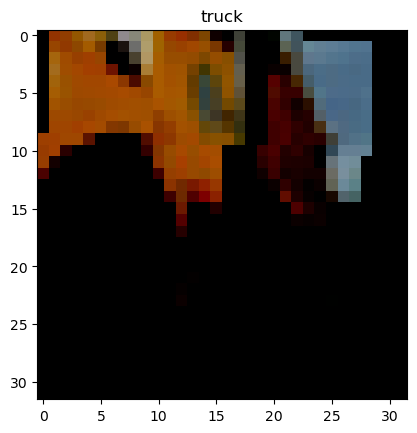

In [6]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for image, label in trainLoader:
    break
rand = np.random.randint(batch_size)
image = image[rand].numpy()
image = np.transpose(image, (1, 2, 0))
plt.imshow(image)
plt.title(classes[label[rand]])
plt.show()

## Model

This is the Resnet18 model without the last two blocks. I used the internet for the "downsample" part of the model.

In [7]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = downsample
        
    def forward(self, x):
        out = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            out = self.downsample(out)
        x += out
        x = self.relu(x)
        return x

In [8]:
class Resnet18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        super(Resnet18, self).__init__()
                
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, padding=3, stride=2)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.first = self.make_layers(64, 64, 1)
        self.second = self.make_layers(64, 128, 2)
        self.third = self.make_layers(128, 256, 2)
        self.fourth = self.make_layers512(256, 512, 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.first(x)
        x = self.second(x)
        x = self.third(x)
        x = self.fourth(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
    def make_layers(self, in_channels, out_channels, stride):
        downsample = None
        
        if stride != 1:
            downsample = self.downsample(in_channels, out_channels)
        
        return nn.Sequential(
            Block(in_channels, out_channels, downsample=downsample, stride=stride), 
            Block(out_channels, out_channels))
    
    def make_layers512(self, in_channels, out_channels, stride):
        downsample = None
        
        if stride != 1:
            downsample = self.downsample(in_channels, out_channels)
        
        return Block(in_channels, out_channels, downsample=downsample, stride=stride)
    
    def downsample(self, in_channels, out_channels):
        return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2), 
                nn.BatchNorm2d(out_channels))

## Train

I tested different values for hyperparameters, and used the best ones.

In [10]:
# Load the pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [11]:
model = Resnet18(3, 10)
model.conv1.weight.data = resnet18.conv1.weight.data

In [17]:
model.to(device)
lr = 0.05
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.1)
epochs = 25

In [18]:
def get_lr(optimizer):
    for p in optimizer.param_groups:
        return p["lr"]

In [19]:
train_loss = []
validation_loss = []
best_loss = np.inf
for epoch in range(epochs):
    
    print(f"Start the training of epoch {epoch+1}")
    
    training_loss = 0.0
    valid_loss = 0.0
    
    sum_labels = torch.tensor([]).to(device)
    sum_preds = torch.tensor([]).to(device)
    val_labels = torch.tensor([]).to(device)
    val_preds = torch.tensor([]).to(device)
    
    model.train()
    for batch, data in enumerate(tqdm.tqdm(trainLoader)):
        
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
#         writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        sum_labels = torch.cat([sum_labels, labels], dim=0)
        sum_preds = torch.cat([sum_preds, preds], dim=0)
        
        training_loss += loss.item()
        
#     writer.add_scalar("learning rate", get_lr(optimizer), epoch)
    scheduler.step()
        
        
    
    corr = sum_preds.eq(sum_labels).sum().item()
#     writer.add_scalar("Accuracy/train", corr/40000, epoch)
    train_loss.append(training_loss/len(trainLoader))
    print(f"training {epoch+1} accuracy = {corr/40000} loss = {training_loss/len(trainLoader)}")
    print()
    print(f"Start the validation of epoch {epoch+1}")
    
    model.eval()
    with torch.no_grad():
        for batch, data in enumerate(tqdm.tqdm(validLoader)):
        
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
#             writer.add_scalar("Loss/valid", loss, epoch)
            preds = outputs.argmax(1)
            val_labels = torch.cat([val_labels, labels], dim=0)
            val_preds = torch.cat([val_preds, preds], dim=0)

            valid_loss += loss.item()
            
    corr = val_preds.eq(val_labels).sum().item()
#     writer.add_scalar("Accuracy/valid", corr/10000, epoch)
    validation_loss.append(valid_loss/len(validLoader))
    print(f"validation {epoch+1} accuracy = {corr/10000} loss = {valid_loss/len(validLoader)}")
    
    if best_loss > valid_loss/len(validLoader):
        best_loss = valid_loss/len(validLoader)
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"best loss is {best_loss}")
    
    print("-----------------------------------------")
    print()

# writer.flush()

Start the training of epoch 1


  0%|          | 0/1250 [00:00<?, ?it/s]

training 1 accuracy = 0.7343 loss = 0.7652120380043983

Start the validation of epoch 1


  0%|          | 0/313 [00:00<?, ?it/s]

validation 1 accuracy = 0.7073 loss = 0.8436903332749875
best loss is 0.8436903332749875
-----------------------------------------

Start the training of epoch 2


  0%|          | 0/1250 [00:00<?, ?it/s]

training 2 accuracy = 0.740975 loss = 0.7445063116312027

Start the validation of epoch 2


  0%|          | 0/313 [00:00<?, ?it/s]

validation 2 accuracy = 0.7381 loss = 0.755583284761959
best loss is 0.755583284761959
-----------------------------------------

Start the training of epoch 3


  0%|          | 0/1250 [00:00<?, ?it/s]

training 3 accuracy = 0.753675 loss = 0.7088395816326142

Start the validation of epoch 3


  0%|          | 0/313 [00:00<?, ?it/s]

validation 3 accuracy = 0.7308 loss = 0.7863044210325796
-----------------------------------------

Start the training of epoch 4


  0%|          | 0/1250 [00:00<?, ?it/s]

training 4 accuracy = 0.76185 loss = 0.6924506544828415

Start the validation of epoch 4


  0%|          | 0/313 [00:00<?, ?it/s]

validation 4 accuracy = 0.7502 loss = 0.7292473809882856
best loss is 0.7292473809882856
-----------------------------------------

Start the training of epoch 5


  0%|          | 0/1250 [00:00<?, ?it/s]

training 5 accuracy = 0.765275 loss = 0.6740748313069344

Start the validation of epoch 5


  0%|          | 0/313 [00:00<?, ?it/s]

validation 5 accuracy = 0.7517 loss = 0.7007717884862765
best loss is 0.7007717884862765
-----------------------------------------

Start the training of epoch 6


  0%|          | 0/1250 [00:00<?, ?it/s]

training 6 accuracy = 0.773925 loss = 0.6536783287525177

Start the validation of epoch 6


  0%|          | 0/313 [00:00<?, ?it/s]

validation 6 accuracy = 0.7629 loss = 0.7003792194893566
best loss is 0.7003792194893566
-----------------------------------------

Start the training of epoch 7


  0%|          | 0/1250 [00:00<?, ?it/s]

training 7 accuracy = 0.782225 loss = 0.6379047714829444

Start the validation of epoch 7


  0%|          | 0/313 [00:00<?, ?it/s]

validation 7 accuracy = 0.7587 loss = 0.7008877434669593
-----------------------------------------

Start the training of epoch 8


  0%|          | 0/1250 [00:00<?, ?it/s]

training 8 accuracy = 0.7875 loss = 0.6174419713377952

Start the validation of epoch 8


  0%|          | 0/313 [00:00<?, ?it/s]

validation 8 accuracy = 0.7632 loss = 0.7036905833802665
-----------------------------------------

Start the training of epoch 9


  0%|          | 0/1250 [00:00<?, ?it/s]

training 9 accuracy = 0.7876 loss = 0.6126554244279862

Start the validation of epoch 9


  0%|          | 0/313 [00:00<?, ?it/s]

validation 9 accuracy = 0.7538 loss = 0.7201949775980684
-----------------------------------------

Start the training of epoch 10


  0%|          | 0/1250 [00:00<?, ?it/s]

training 10 accuracy = 0.79355 loss = 0.5950099945902825

Start the validation of epoch 10


  0%|          | 0/313 [00:00<?, ?it/s]

validation 10 accuracy = 0.7685 loss = 0.6737649356500028
best loss is 0.6737649356500028
-----------------------------------------

Start the training of epoch 11


  0%|          | 0/1250 [00:00<?, ?it/s]

training 11 accuracy = 0.7961 loss = 0.5866341374635696

Start the validation of epoch 11


  0%|          | 0/313 [00:00<?, ?it/s]

validation 11 accuracy = 0.7632 loss = 0.699363924777165
-----------------------------------------

Start the training of epoch 12


  0%|          | 0/1250 [00:00<?, ?it/s]

training 12 accuracy = 0.800525 loss = 0.574549424958229

Start the validation of epoch 12


  0%|          | 0/313 [00:00<?, ?it/s]

validation 12 accuracy = 0.7777 loss = 0.6512248445623599
best loss is 0.6512248445623599
-----------------------------------------

Start the training of epoch 13


  0%|          | 0/1250 [00:00<?, ?it/s]

training 13 accuracy = 0.8046 loss = 0.5607402901351451

Start the validation of epoch 13


  0%|          | 0/313 [00:00<?, ?it/s]

validation 13 accuracy = 0.7757 loss = 0.6714828603279096
-----------------------------------------

Start the training of epoch 14


  0%|          | 0/1250 [00:00<?, ?it/s]

training 14 accuracy = 0.80885 loss = 0.5529933077096939

Start the validation of epoch 14


  0%|          | 0/313 [00:00<?, ?it/s]

validation 14 accuracy = 0.7835 loss = 0.6315671541629889
best loss is 0.6315671541629889
-----------------------------------------

Start the training of epoch 15


  0%|          | 0/1250 [00:00<?, ?it/s]

training 15 accuracy = 0.81155 loss = 0.5458098774909973

Start the validation of epoch 15


  0%|          | 0/313 [00:00<?, ?it/s]

validation 15 accuracy = 0.7805 loss = 0.6455451603800344
-----------------------------------------

Start the training of epoch 16


  0%|          | 0/1250 [00:00<?, ?it/s]

training 16 accuracy = 0.8157 loss = 0.5305789579212665

Start the validation of epoch 16


  0%|          | 0/313 [00:00<?, ?it/s]

validation 16 accuracy = 0.7792 loss = 0.6380455574383751
-----------------------------------------

Start the training of epoch 17


  0%|          | 0/1250 [00:00<?, ?it/s]

training 17 accuracy = 0.817225 loss = 0.5270429359197617

Start the validation of epoch 17


  0%|          | 0/313 [00:00<?, ?it/s]

validation 17 accuracy = 0.7896 loss = 0.6272696065731322
best loss is 0.6272696065731322
-----------------------------------------

Start the training of epoch 18


  0%|          | 0/1250 [00:00<?, ?it/s]

training 18 accuracy = 0.8199 loss = 0.5177012332797051

Start the validation of epoch 18


  0%|          | 0/313 [00:00<?, ?it/s]

validation 18 accuracy = 0.7886 loss = 0.6259147138260424
best loss is 0.6259147138260424
-----------------------------------------

Start the training of epoch 19


  0%|          | 0/1250 [00:00<?, ?it/s]

training 19 accuracy = 0.824875 loss = 0.5116922243654728

Start the validation of epoch 19


  0%|          | 0/313 [00:00<?, ?it/s]

validation 19 accuracy = 0.7872 loss = 0.6394863903236846
-----------------------------------------

Start the training of epoch 20


  0%|          | 0/1250 [00:00<?, ?it/s]

training 20 accuracy = 0.8266 loss = 0.5027940333664417

Start the validation of epoch 20


  0%|          | 0/313 [00:00<?, ?it/s]

validation 20 accuracy = 0.791 loss = 0.6103439188708132
best loss is 0.6103439188708132
-----------------------------------------

Start the training of epoch 21


  0%|          | 0/1250 [00:00<?, ?it/s]

training 21 accuracy = 0.82655 loss = 0.4955896229505539

Start the validation of epoch 21


  0%|          | 0/313 [00:00<?, ?it/s]

validation 21 accuracy = 0.8012 loss = 0.5879983763439587
best loss is 0.5879983763439587
-----------------------------------------

Start the training of epoch 22


  0%|          | 0/1250 [00:00<?, ?it/s]

training 22 accuracy = 0.829925 loss = 0.4863865560054779

Start the validation of epoch 22


  0%|          | 0/313 [00:00<?, ?it/s]

validation 22 accuracy = 0.7883 loss = 0.6319207644786317
-----------------------------------------

Start the training of epoch 23


  0%|          | 0/1250 [00:00<?, ?it/s]

training 23 accuracy = 0.830625 loss = 0.48344070700407027

Start the validation of epoch 23


  0%|          | 0/313 [00:00<?, ?it/s]

validation 23 accuracy = 0.7924 loss = 0.6205020410755572
-----------------------------------------

Start the training of epoch 24


  0%|          | 0/1250 [00:00<?, ?it/s]

training 24 accuracy = 0.833975 loss = 0.4743595877707005

Start the validation of epoch 24


  0%|          | 0/313 [00:00<?, ?it/s]

validation 24 accuracy = 0.7888 loss = 0.6195503344741492
-----------------------------------------

Start the training of epoch 25


  0%|          | 0/1250 [00:00<?, ?it/s]

training 25 accuracy = 0.8374 loss = 0.47075051414966584

Start the validation of epoch 25


  0%|          | 0/313 [00:00<?, ?it/s]

validation 25 accuracy = 0.7852 loss = 0.6328265083769259
-----------------------------------------



## Plot the loss

I used early stopping to overcome the overfitting problem.
Also, "Tensorboard" is an option.

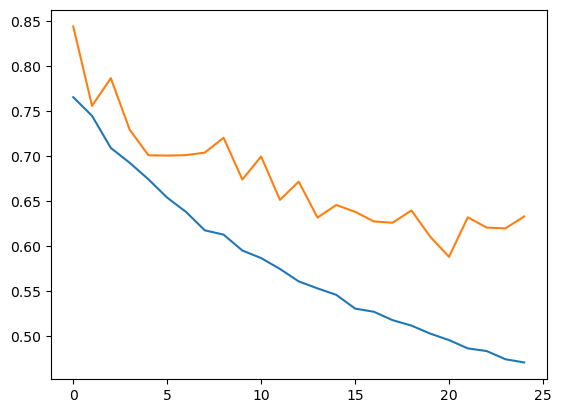

In [20]:
plt.plot(train_loss)
plt.plot(validation_loss)

plt.show()

## Test

In [21]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
total = 0
corr = 0
with torch.no_grad():
    for _, data in enumerate(tqdm.tqdm(testLoader)):
        
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        total += labels.size(0)
        corr += preds.eq(labels).sum().item()

print(f"The accuracy is {corr/total}")

  0%|          | 0/313 [00:00<?, ?it/s]

The accuracy is 0.8354


In [22]:
img_path = '/kaggle/input/dogggs/dog.jpeg'

In [23]:
def Inference(img_path):
    model.load_state_dict(torch.load('best_model.pt'))
    with torch.no_grad():
        image = Image.open(img_path)
        torchvision.transforms.Resize(32*32)(image)
        transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        img_tensor = transform(image).float()
        model.eval()
        img_tensor = img_tensor.to(device)
        img_tensor = img_tensor.reshape(1,3,32,32)
        output = model(img_tensor)
        m = nn.Softmax(dim=1)
        out = m(output)
        prob = out/torch.sum(out, dim=-1).unsqueeze(-1)
        prob = torch.mul(prob,100)
        prob = prob[0].tolist()
    for i in range(len(classes)):
        print(f"The {classes[i]} probability is {round(prob[i], 2)}%.")
    print("------------------------------------")
    print(f"The winner is the {classes[prob.index(max(prob))]} class!")

In [24]:
Inference(img_path)

The plane probability is 0.31%.
The car probability is 0.67%.
The bird probability is 0.23%.
The cat probability is 75.38%.
The deer probability is 2.06%.
The dog probability is 19.17%.
The frog probability is 1.31%.
The horse probability is 0.56%.
The ship probability is 0.09%.
The truck probability is 0.22%.
------------------------------------
The winner is the cat class!
